<a href="https://colab.research.google.com/github/mirajjara/DeepLearningResearch/blob/main/DeepLearningResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Miraj Jara - Custom made Convolutional Neural Network

The purpose of this notebook is to create a CNN capable of classifying medical images into three categories: benign, malignant, and normal. The network will be trained on a dataset of labeled images and evaluated on its accuracy and performance.

To start, we will clone the Breast Ultrasound Images Dataset repository from GitHub and set the path to the dataset. We will then list the subfolders in the dataset using os.listdir(dataset_path), which should output the categories benign, malignant, and normal.

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Dependencies

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [3]:
dataset_path = "/content/drive/MyDrive/summer research '24/Dataset_BUSI_with_GT"
os.listdir(dataset_path)  # lists the subfolders (benign, malignant, normal)

['malignant', 'normal', 'benign']

##About the Dataset

Data collection: Breast ultrasound images from women aged 25-75, collected in 2018

Number of patients: 600 femalepatients

Number of images: 780 images, with an average size of 500x500 pixels, in PNG format

Ground truth images: Included with the original images

Classes: Images are categorized into three classes: normal, benign, and malignant

Citation: If you use this dataset, please cite the following paper:
Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863

##Sample of the BUSI Dataset

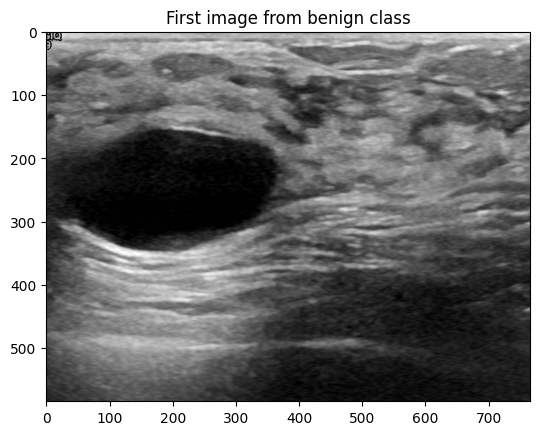

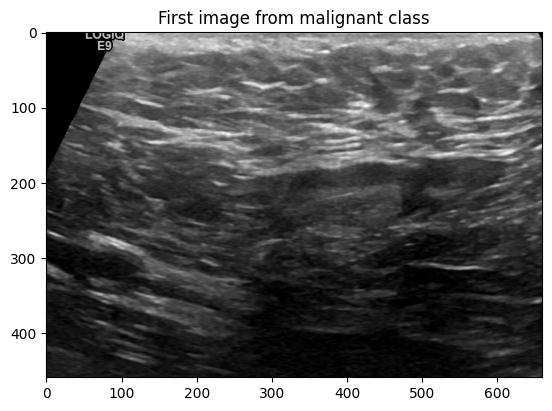

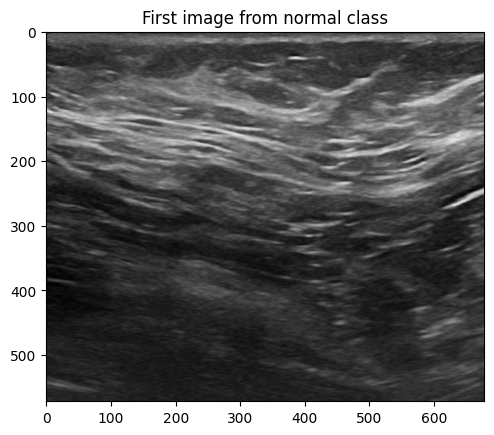

In [4]:
# Define the subfolders (classes)
subfolders = ['benign', 'malignant', 'normal']

# Loop through each subfolder (class)
for subfolder in subfolders:
  # Get a list of image files in the subfolder
  image_files = os.listdir(os.path.join(dataset_path, subfolder))

  # Get the first image file
  image_file = image_files[0]

  # Display the image
  img = plt.imread(os.path.join(dataset_path, subfolder, image_file))
  plt.imshow(img)
  plt.title(f'First image from {subfolder} class')
  plt.show()

#Data Preprocessing



##Resizing images

The following code resizes all images in the dataset to 224x224

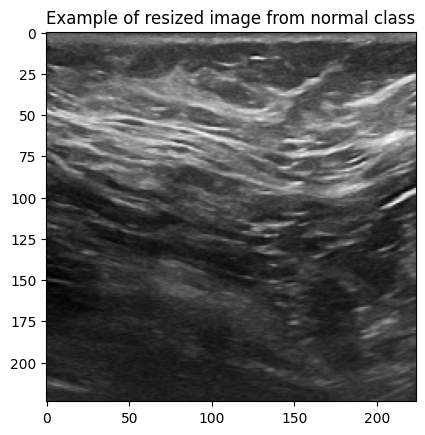

In [5]:
# Define the target image shape, e.g., (224, 224) for a model that expects 224x224 images
IMAGE_SHAPE = (224, 224)

def prepare_image(file):
    # Read the image from the file in grayscale mode
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    # Resize the image to the target size
    img = cv2.resize(img, IMAGE_SHAPE)

    # Normalize the image to [0, 1] range
    img = img / 255.0

    # ensuring the shape is (height, width, 1)
    img = img.reshape((*IMAGE_SHAPE, 1))

    return img

img = prepare_image(os.path.join(dataset_path, subfolder, image_file))
plt.imshow(img.reshape(IMAGE_SHAPE), cmap='gray')
plt.title(f'Example of resized image from {subfolder} class')
plt.show()

In [6]:
import glob

directories = os.listdir(dataset_path) # read the folders

files = [] # save all images for each folder
labels = [] # set for each image the name of it

# read files for each directory
for folder in directories:

    fileList = glob.glob(dataset_path + '/'+ folder + '/*')
    labels.extend([folder for l in fileList])
    files.extend(fileList)

len(files), len(labels)

# create two lists to hold only non-mask images and label for each one
selected_files = []
selected_labels = []

for file, label in zip(files, labels):
    if 'mask' not in file:
        selected_files.append(file)
        selected_labels.append(label)


len(selected_files), len(selected_labels)

(780, 780)

In [7]:
# the dictionary holds list of images and for each one has its target/label
images = {
    'image': [],
    'target': []
}

for i, (file, label) in enumerate(zip(selected_files, selected_labels)):
    images['image'].append(prepare_image(file))
    images['target'].append(label)

print('Finished.')

Finished.


In [18]:
# convert lists to arrays
images['image'] = np.array(images['image'])
images['target'] = np.array(images['target'])

# encode the target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images['target'] = le.fit_transform(images['target'])
images['target'] = tf.keras.utils.to_categorical(images['target'])

classes = le.classes_ # get the classes for each target
print(f'the target classes are: {classes}')

the target classes are: [0 1 2]


##Spliting the data

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images['image'], images['target'], test_size=0.20)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((624, 224, 224, 1), (156, 224, 224, 1), (624, 3), (156, 3))

#Creating the Model

The model consists of 9 layers: 3 convolutional layers, 3 max pooling layers, 1 flatten layer, 1 dense layer, and 1 dropout layer.

The output shape of each layer is displayed, showing the number of feature maps or units in each layer.
The number of parameters (Param #) is displayed for each layer, with a total of approximately 11 million parameters in the model.
All parameters are trainable, indicating that the model is ready for training.

In [23]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Define the CNN model architecture
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # 3 classes: benign, malignant, normal
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Create a new model with the same architecture as the original model
incept_model = keras.models.Model(inputs = model.input, outputs = model.output)

# Compile the new model
incept_model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(), metrics = ['accuracy'])

# Print the model summaries
model.summary()
incept_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 26, 26, 128)      

In [24]:
history = incept_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
20/20 [==============================] - 84s 4s/step - loss: 1.0947 - accuracy: 0.5112 - val_loss: 0.9452 - val_accuracy: 0.5385
Epoch 2/10
20/20 [==============================] - 78s 4s/step - loss: 0.9367 - accuracy: 0.5769 - val_loss: 0.8396 - val_accuracy: 0.5962
Epoch 3/10
20/20 [==============================] - 73s 4s/step - loss: 0.8581 - accuracy: 0.6202 - val_loss: 0.8017 - val_accuracy: 0.6474
Epoch 4/10
20/20 [==============================] - 78s 4s/step - loss: 0.7396 - accuracy: 0.6683 - val_loss: 0.6708 - val_accuracy: 0.7179
Epoch 5/10
20/20 [==============================] - 75s 4s/step - loss: 0.6180 - accuracy: 0.7308 - val_loss: 0.7026 - val_accuracy: 0.6987
Epoch 6/10
20/20 [==============================] - 74s 4s/step - loss: 0.5203 - accuracy: 0.7917 - val_loss: 0.6948 - val_accuracy: 0.7564
Epoch 7/10
20/20 [==============================] - 72s 4s/step - loss: 0.4016 - accuracy: 0.8606 - val_loss: 0.7124 - val_accuracy: 0.7308
Epoch 8/10
20/20 [==

In [25]:
model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

5/5 [==============================] - 7s 899ms/step - loss: 0.6282 - accuracy: 0.8269


[0.6281668543815613, 0.8269230723381042]

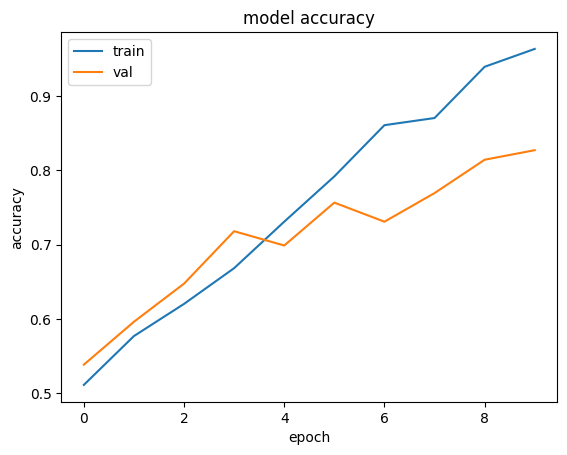

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Confusion Matrix

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

predicted = []
for item in incept_model.predict(x_test):
    predicted.append(np.argmax(item))

y_test_multiclass = np.argmax(y_test, axis=1)
conf = confusion_matrix(y_test_multiclass, predicted)

print(conf)

5/5 [==============================] - 7s 1s/step
[[75  7  2]
 [ 7 42  3]
 [ 6  2 12]]


Text(0.5, 155.72222222222217, 'Predicted')

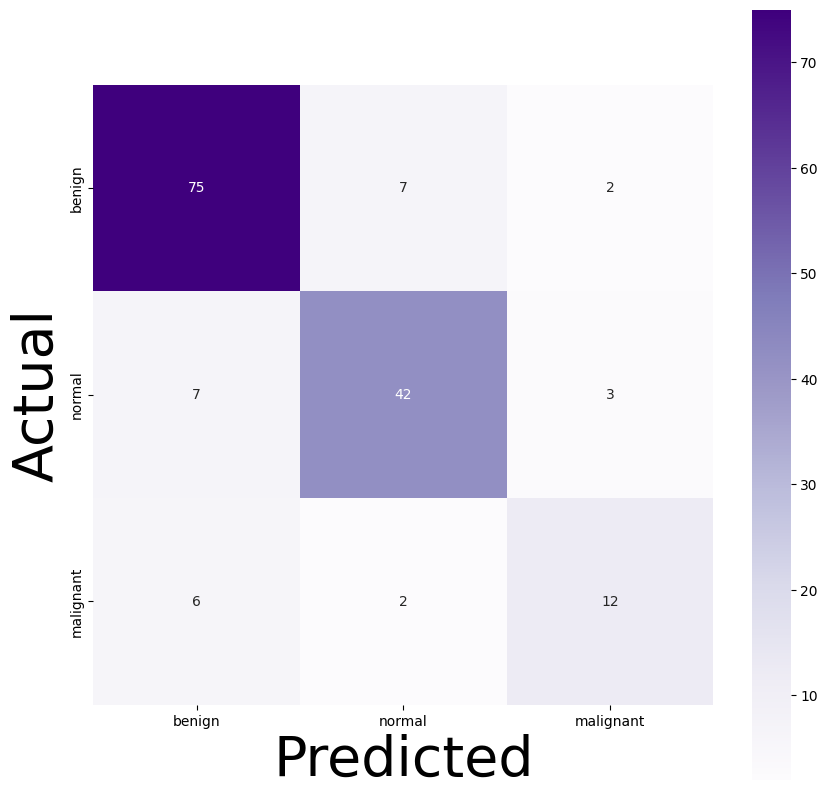

In [30]:
#Heatmap
info = [
    'benign'   ,  # 0
    'normal'   ,  # 1
    'malignant',  # 2
]
plt.figure(figsize = (10,10))
ax = sns.heatmap(conf, cmap=plt.cm.Purples, annot=True, square=True, xticklabels = info, yticklabels = info)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)